In [153]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [154]:
from data import load_data

vids = ['ugJ-rYS-9JU']
data = load_data(vids)

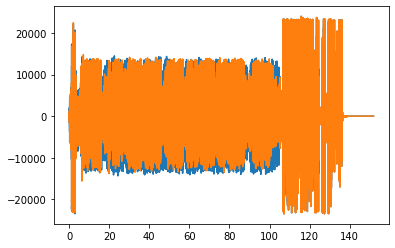

In [155]:
d = data[0]
x, t = d.data, d.time
l, r = x[:, 0], x[:, 1]

plt.plot(t, l)
plt.plot(t, r);

Let's FFT

In [156]:
from scipy.fft import fft, fftfreq
from scipy.signal.windows import hann, tukey
from scipy.signal import savgol_filter

from matplotlib.animation import FuncAnimation

Get some curves?

In [188]:
t_window = 0.1 # seconds
n_window = int(t_window*d.fs) # samples

t_start, t_end = 20, 100
i_start, i_end = int(t_start*d.fs), int(t_end*d.fs)
i_window = np.arange(i_start, i_end, n_window)

# x-axis
xf = fftfreq(n_window, d.dt)[:n_window//2]

# Set frequency limits
f_min, f_max = 250, 1000
mask = (xf >= f_min) & (xf <= f_max)
xf = xf[mask]

w = hann(n_window)
def process(signal, i):
    f = fft(w*signal[i:i + n_window])
    mag = np.abs(f[:n_window//2])[mask]
    return 20*np.log10(mag/mag.max()) # dB

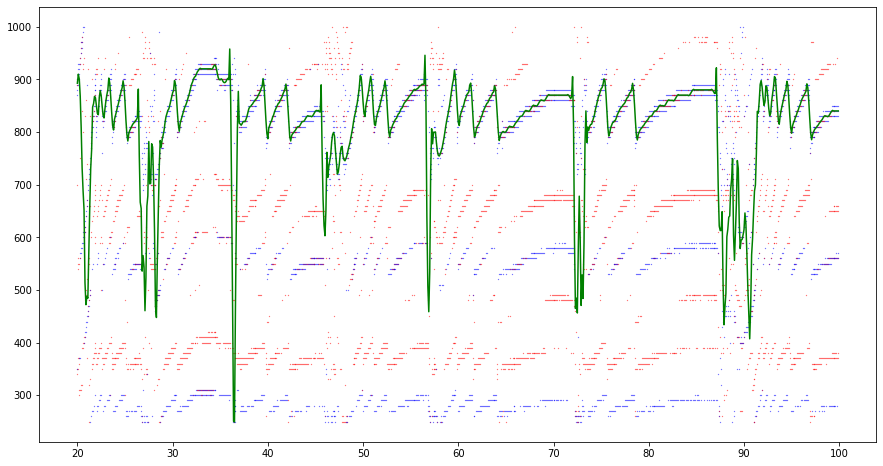

In [189]:
N = 5
def top_n(signal):
    return signal.argsort()[-N:][::-1]

# Really quick get maxima
mls, mrs = [], []
for i in i_window:
    fl, fr = process(l, i), process(r, i)
    mls.append(top_n(fl)), mrs.append(top_n(fr))

fig = plt.figure(figsize=(15, 8))
    
for i in range(N):
    plt.scatter(i_window*d.dt, [xf[ml[i]] for ml in mls], color='red', s=0.05)
    plt.scatter(i_window*d.dt, [xf[mr[i]] for mr in mrs], color='blue', s=0.05)

# And plot the best
best = savgol_filter(xf[np.array(mrs).T[0, :]], 7, 3)

plt.plot(i_window*d.dt, best, color='green')

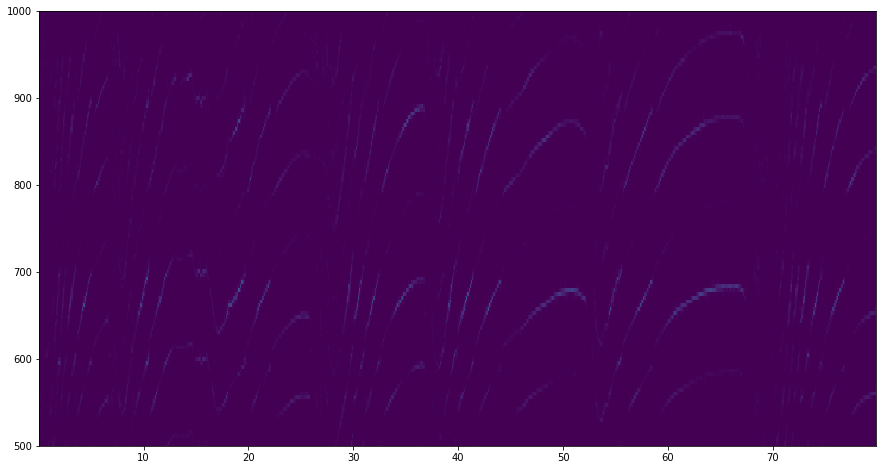

In [162]:
# Try built-in
from scipy.signal import spectrogram

plt.figure(figsize=(15, 8))

f, t, S = spectrogram(l[i_start:i_end], fs=d.fs, nperseg=10000, noverlap=5000)
plt.pcolormesh(t, f, S)
plt.ylim([f_min, f_max]);